In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb

In [2]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)

In [3]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

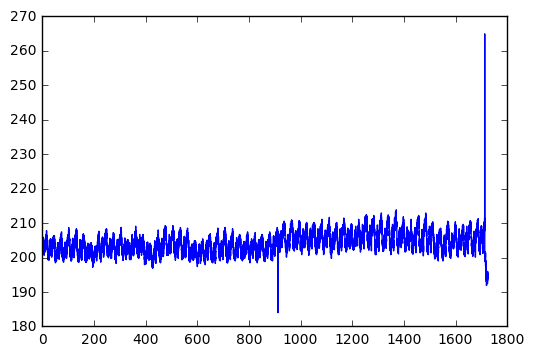

9120
9121
9122
9123
9124
9125
9126
9127


In [6]:
mat_file1 = io.loadmat('2014_Dataset1.mat')
t = mat_file1['t']
p1 = mat_file1['p1']
p2 = mat_file1['p2']
x = np.arange(0,len(p2)/10,0.1)[:,None]
plt.plot(x,p2)
plt.show()
for i in range(len(x)-1):
    if p2[i]<190:
        print (i)

In [5]:
import pickle
f = open('d:/hyperparameter','rb')
gp = pickle.load(f)
f.close()

# EVT-GP

In [7]:
def rbf(X,xt,m):
    Xt = xt*np.ones(len(X))[:,None]
    k = ((X-Xt)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    n = np.sum(ke)
    return n

def z_score(n):
    alpha = 2*np.log(n)**(-0.5)
    beta = (2*np.log(n))**(0.5) - (np.log(np.log(n)+np.log(2*np.pi)))/(2*(2*np.log(n))**0.5)
    zp = beta-alpha*np.log(-np.log(0.95))
    return zp

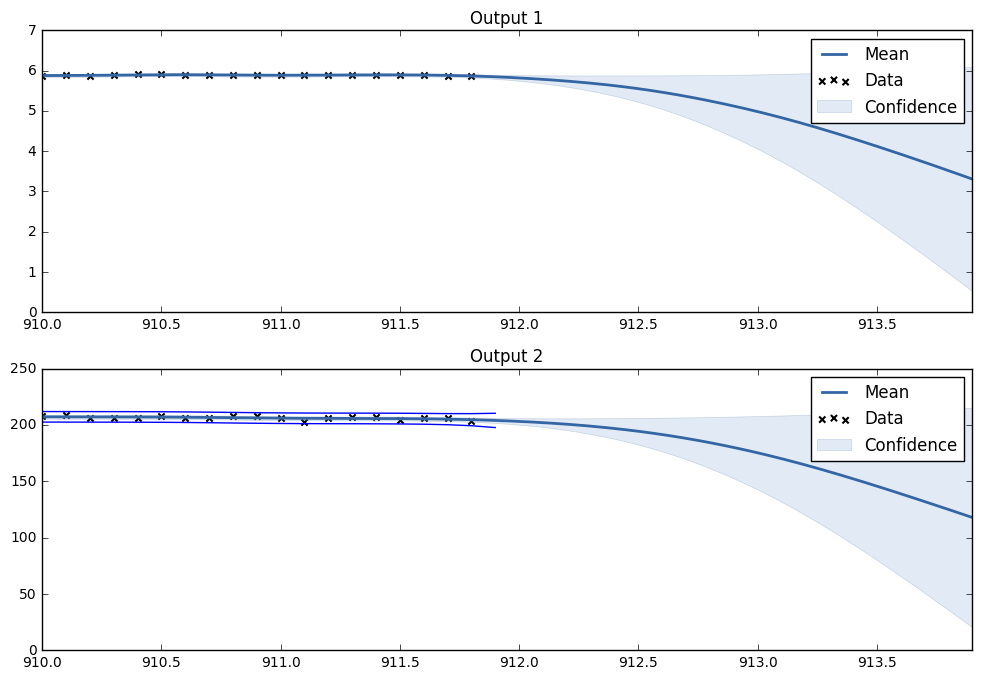

In [9]:
s = 9019
l = 100
it = list(range(s,s+l))
kt = it.copy()
anomal_points = []
kern = gp.kern.copy()
step = 1
for i in range(1):
    # 기존 100개 model에 z 구하기
    new = it[len(it)-1]+step
    
    mul = GPy.models.GPCoregionalizedRegression([x[kt],x[it]],[p1[kt],p2[it]],kernel = kern)
    mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    test_x = x[new]
    n = rbf(x[it],test_x,mul)
    zp = z_score(n)

    # 벗어나는 x찾기
    jt = it + list([new])
    X,Y,I = build_XY([x[jt],x[jt]],[p1[jt],p2[jt]])
    mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]

    
    
    plot_2outputs(mul, xlim=(x[9100],x[9139]),x_1=x[it],x_2=x[it])
    con_ue = mu2 + np.sqrt(var2)*zp
    con_le = mu2 - np.sqrt(var2)*zp
    plt.plot(x[jt],con_ue,'blue')
    plt.plot(x[jt],con_le,'blue')
    plt.show()
    
    
    
    if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
        anomal_points.append(new)
        it = it
        kt = kt + list([new])
        step += 1
    else:
        it.pop(0)
        it = it + list([new])
        kt = it.copy()
        step = 1

In [10]:
anomal_points

[9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127]

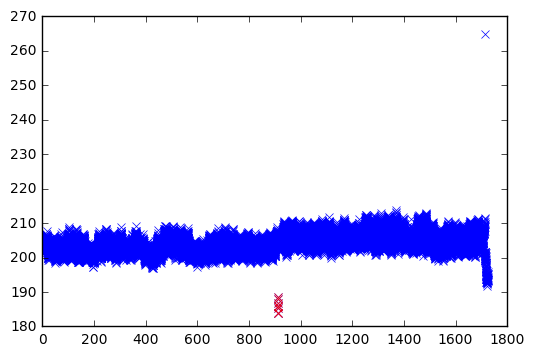

In [11]:
plt.plot(x,p2,'kx',color='blue')
plt.plot(x[anomal_points],p2[anomal_points],'kx',color='red')
plt.show()

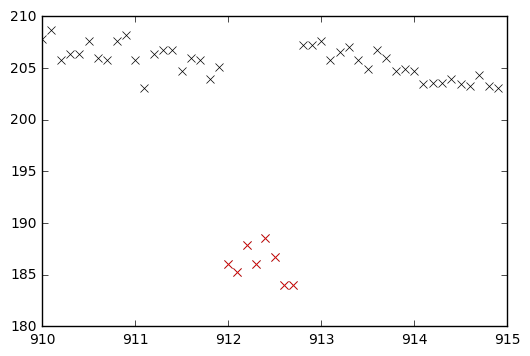

In [12]:
ano = anomal_points[0:11]
plt.plot(x[9100:9150],p2[9100:9150],'kx')
plt.plot(x[ano],p2[ano],'kx',color='red')
plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'list'